In [ ]:
# Core data handling
import pandas as pd
import numpy as np
from pathlib import Path

import re
from datetime import datetime
import dateutil.parser

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [4]:
csv_path = Path("logbook_assignment1.csv")
if csv_path is None:
    raise FileNotFoundError("Could not find 'logbook_assignment1.csv' in the working directory")

In [5]:
df = pd.read_csv(csv_path, dtype=str)  # read everything as string first (dataset is messy)
print(f"Loaded {len(df):,} rows from: {csv_path}")

Loaded 1,174,870 rows from: logbook_assignment1.csv


In [6]:
# Peek at the columns we care about (ensure expected names exist)
expected_cols = ['date_fueled', 'date_captured', 'odometer', 'gallons', 'cost_per_gallon', 'total_spent', 'mpg', 'miles', 'user_url']
missing = [c for c in expected_cols if c not in df.columns]
if missing:
    print("Warning: Missing expected columns:", missing)
else:
    print("All expected columns present.")

All expected columns present.


## 1.1 Date Fields
### 1. percentage of date fueled entries that are not proper dates.
Helpers to parse dates in the form eg. "Jan 9 2014" and compute validity masks

In [7]:
def clean_date_str(s: pd.Series) -> pd.Series:
    """
    Light string cleanup:
    - Ensure string type
    - Strip whitespace
    - Remove stray single/double quotes
    - Collapse multiple internal spaces to a single space
    """
    s = s.astype("string")
    s = s.str.strip()
    s = s.str.replace('"', '', regex=False).str.replace("'", "", regex=False)
    s = s.str.replace(r"\s+", " ", regex=True)  # compress whitespace
    return s

def parse_mmmdyyyy(series: pd.Series) -> pd.Series:
    """
    Parse dates strictly in format '%b %d %Y' e.g., 'Jan 9 2014'.
    Returns datetime64[ns] with NaT for invalids.
    """
    cleaned = clean_date_str(series)
    parsed = pd.to_datetime(cleaned, format="%b %d %Y", errors="coerce")
    return parsed

# Create parsed columns (do not mutate originals)
parsed_date_fueled = parse_mmmdyyyy(df['date_fueled'])
parsed_date_captured = parse_mmmdyyyy(df['date_captured'])

valid_fueled_mask = parsed_date_fueled.notna()
valid_captured_mask = parsed_date_captured.notna()

percent_not_proper_date = (1.0 - valid_fueled_mask.mean()) * 100.0
print(f"Q1.1(1) — Percentage of 'date_fueled' entries that are NOT proper dates: {percent_not_proper_date:.2f}%")
print(f"Valid 'date_fueled': {valid_fueled_mask.sum():,} / {len(df):,}")
print(f"Invalid 'date_fueled': {(~valid_fueled_mask).sum():,} / {len(df):,}")


Q1.1(1) — Percentage of 'date_fueled' entries that are NOT proper dates: 11.68%
Valid 'date_fueled': 1,037,660 / 1,174,870
Invalid 'date_fueled': 137,210 / 1,174,870


### Q1.1(2) Fill proxy dates

In [9]:
# If 'date_fueled' is invalid and 'date_captured' is valid, use 'date_captured' as a proxy.
# We'll create a clean datetime column 'date_fueled_clean' for analysis.

df['date_fueled_clean'] = parsed_date_fueled  # start with parsed 'date_fueled'
to_fill_mask = (~valid_fueled_mask) & (valid_captured_mask)

filled_count = to_fill_mask.sum()
df.loc[to_fill_mask, 'date_fueled_clean'] = parsed_date_captured.loc[to_fill_mask]

# Report post-fill validity
post_valid_mask = df['date_fueled_clean'].notna()
post_invalid_count = (~post_valid_mask).sum()
post_invalid_pct = (post_invalid_count / len(df)) * 100.0

print(f"Q1.1(2) — Filled proxy dates from 'date_captured' for {filled_count:,} rows.")
print(f"After filling, remaining invalid 'date_fueled_clean': {post_invalid_count:,} rows ({post_invalid_pct:.2f}%).")


Q1.1(2) — Filled proxy dates from 'date_captured' for 137,210 rows.
After filling, remaining invalid 'date_fueled_clean': 0 rows (0.00%).


### Q1.1(3) Convert the 'date_fueled' column to proper datetime, invalids as NaT
- date_fueled_dt has the original dates formatted
- date_fueled_clean had the dates with the proxys formatted

In [12]:
df['date_fueled_dt'] = pd.to_datetime(df['date_fueled'], format="%b %d %Y", errors="coerce")

# Check how many are NaT
invalid_count = df['date_fueled_dt'].isna().sum()
invalid_pct = (invalid_count / len(df)) * 100

print(f"Q1.1(3) — Converted 'date_fueled' to datetime. Invalid entries set to NaT: {invalid_count:,} ({invalid_pct:.2f}%)")

# Update 'date_fueled_clean' to ensure it is in datetime format with NaT for invalids.
# This column had proxies filled from 'date_captured' earlier.

df['date_fueled_clean'] = pd.to_datetime(df['date_fueled_clean'], errors="coerce")

# Recheck invalids
invalid_count_clean = df['date_fueled_clean'].isna().sum()
invalid_pct_clean = (invalid_count_clean / len(df)) * 100

print(f"'date_fueled_clean' updated to datetime. Remaining invalid entries (NaT): {invalid_count_clean:,} ({invalid_pct_clean:.4f}%).")

Q1.1(3) — Converted 'date_fueled' to datetime. Invalid entries set to NaT: 137,210 (11.68%)
'date_fueled_clean' updated to datetime. Remaining invalid entries (NaT): 0 (0.0000%).


### Q1.1(4) Remove dates in the future or earlier than 2005 from 'date_fueled_clean'

In [13]:
# Define valid date range: 2005-01-01 <= date <= today
min_date = pd.Timestamp("2005-01-01")
max_date = pd.Timestamp.today().normalize()

initial_count = len(df)
valid_mask = (df['date_fueled_clean'] >= min_date) & (df['date_fueled_clean'] <= max_date)

removed_count = (~valid_mask).sum()
df = df.loc[valid_mask].copy()
final_count = len(df)

print(f"Q1.1(4) — Removed {removed_count:,} rows with dates outside [2005, today].")
print(f"Remaining rows: {final_count:,} (from {initial_count:,}).")

Q1.1(4) — Removed 570 rows with dates outside [2005, today].
Remaining rows: 1,174,300 (from 1,174,870).


### Q1.1(5) Plot the distribution of fueling dates

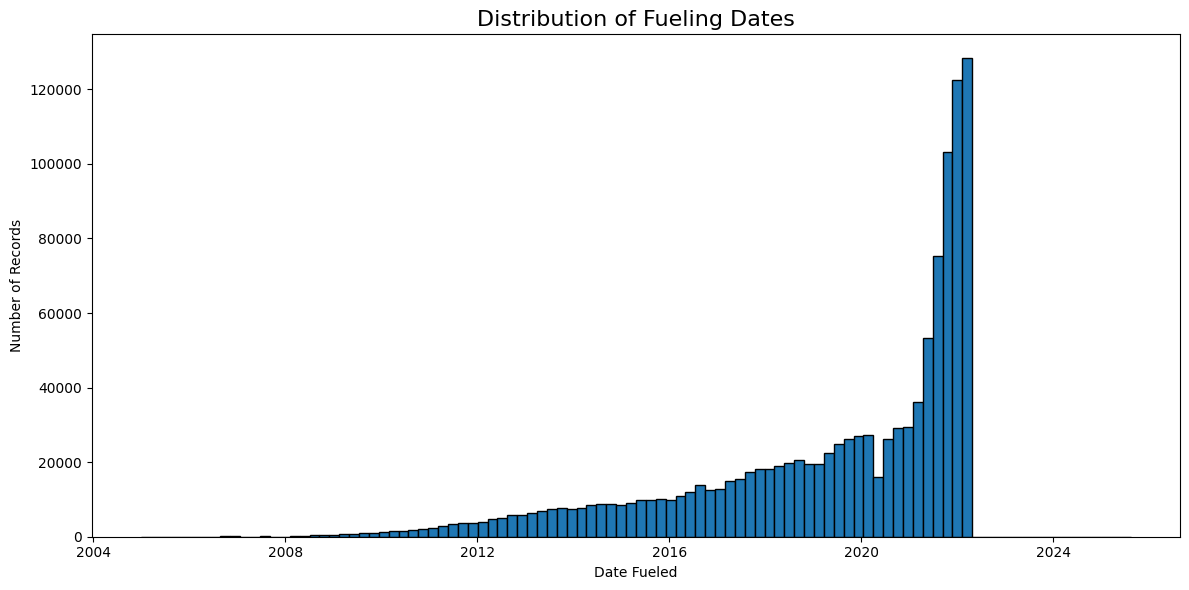

In [14]:
plt.figure(figsize=(12,6))
df['date_fueled_clean'].hist(bins=100, edgecolor='black')
plt.title("Distribution of Fueling Dates", fontsize=16)
plt.xlabel("Date Fueled")
plt.ylabel("Number of Records")
plt.grid(False)
plt.tight_layout()
plt.show()

## 1.2. Numeric Fields

(1) percentage of gallons, miles, and odometer entries are
missing.

In [15]:
numeric_cols = ['gallons', 'miles', 'odometer']

missing_stats = {}
for col in numeric_cols:
    missing_count = df[col].isna().sum() + (df[col] == "").sum()
    missing_pct = (missing_count / len(df)) * 100
    missing_stats[col] = (missing_count, missing_pct)

missing_stats_df = pd.DataFrame(missing_stats, index=["Missing Count", "Missing %"]).T
missing_stats_df

,Missing Count,Missing %
gallons,74171.0,6.316188
miles,1028143.0,87.553692
odometer,149037.0,12.691561


### Q1.2(2) Use interdependence between miles, gallons, and mpg to fill missing values.
Formula: mpg = miles / gallons

In [16]:
#convert columns to numeric (handling commas, etc. will be part of step 1.2(3))
def to_numeric(series):
    return pd.to_numeric(series.str.replace(",", "", regex=False), errors="coerce")

df['gallons_num'] = to_numeric(df['gallons'])
df['miles_num'] = to_numeric(df['miles'])
df['mpg_num'] = to_numeric(df['mpg'])

# Count missing before filling
missing_before = {
    'gallons': df['gallons_num'].isna().sum(),
    'miles': df['miles_num'].isna().sum(),
    'mpg': df['mpg_num'].isna().sum(),
}

# Fill missing mpg when miles and gallons are available
mask = df['mpg_num'].isna() & df['miles_num'].notna() & df['gallons_num'].notna() & (df['gallons_num'] != 0)
df.loc[mask, 'mpg_num'] = df.loc[mask, 'miles_num'] / df.loc[mask, 'gallons_num']

# Fill missing miles when mpg and gallons are available
mask = df['miles_num'].isna() & df['mpg_num'].notna() & df['gallons_num'].notna()
df.loc[mask, 'miles_num'] = df.loc[mask, 'mpg_num'] * df.loc[mask, 'gallons_num']

# Fill missing gallons when mpg and miles are available
mask = df['gallons_num'].isna() & df['mpg_num'].notna() & df['miles_num'].notna() & (df['mpg_num'] != 0)
df.loc[mask, 'gallons_num'] = df.loc[mask, 'miles_num'] / df.loc[mask, 'mpg_num']

# Count missing after filling
missing_after = {
    'gallons': df['gallons_num'].isna().sum(),
    'miles': df['miles_num'].isna().sum(),
    'mpg': df['mpg_num'].isna().sum(),
}

missing_before, missing_after

#74k rows are missing all three fields, so they cannot be recovered.

({'gallons': 74171, 'miles': 1028143, 'mpg': 74171},
 {'gallons': 74171, 'miles': 74171, 'mpg': 74171})

### Q1.2(3) Convert gallons, miles, and odometer to floats

In [20]:
def clean_to_float(series):
    """
    Convert string series with commas as thousand separators into floats.
    Invalid parsing results in NaN.
    """
    if series.dtype == object or pd.api.types.is_string_dtype(series):
        return pd.to_numeric(series.str.replace(",", "", regex=False), errors="coerce")
    else:
        return pd.to_numeric(series, errors="coerce")

df['gallons_clean'] = clean_to_float(df['gallons'])
df['miles_clean'] = clean_to_float(df['miles'])
df['odometer_clean'] = clean_to_float(df['odometer'])

# Check some summary statistics to confirm successful conversion
df[['gallons_clean', 'miles_clean', 'odometer_clean']].describe().T

,count,mean,std,min,25%,50%,75%,max
gallons_clean,1100129.0,12.797430,74.482791,0.0,8.99,11.954,14.939,28380.0
miles_clean,146157.0,342.632296,1915.392554,0.1,225.50,291.600,367.000,195321.2
odometer_clean,1025263.0,104001.086158,340597.635009,0.0,45924.00,91888.000,146925.500,254362100.0


In [36]:
# Print random samples of the numeric fields to inspect values
sample_data = df[['gallons_clean', 'miles_clean', 'odometer_clean']].sample(20, random_state=42)
sample_data

,gallons_clean,miles_clean,odometer_clean
150534,7.843,NaN,132898.0
1136282,10.000,180.0,NaN
629193,6.678,NaN,80806.0
510714,8.728,NaN,167526.0
775089,8.266,NaN,42685.0
545838,8.998,NaN,32496.0
205335,14.207,NaN,63530.0
1107084,12.356,NaN,133887.0
797948,4.751,NaN,63372.0
624190,6.340,NaN,16808.0


## Question 4: Outlier Removal
### Q4.1(1) Identify the top 5 currencies by number of transactions

In [51]:
def extract_currency(val):
    if pd.isna(val):
        return None
    val = str(val).strip()
    # Match leading non-numeric characters (currency symbols/abbreviations)
    match = re.match(r"^([^\d.,\s]+)", val)
    return match.group(1) if match else None

# Create a currency column from total_spent
df['currency'] = df['total_spent'].apply(extract_currency)

# Count number of transactions per currency
currency_counts = df['currency'].value_counts().head(5)

print("Top 5 currencies by number of transactions:")
print(currency_counts)

Top 5 currencies by number of transactions:
currency
$      741953
£       87587
€       59273
CA$     46848
R       36424
Name: count, dtype: int64


### Q4.1 (2): Outlier removal for the top 5 currencies.

The dataset gives gallons (because it’s US-based logging). But fuel is normally compared worldwide in litres (e.g., South Africa, Europe). If we want to look at cost of fuel per unit in different currencies, using gallons is misleading because:
- A US gallon = 3.785 litres
- A UK gallon = 4.546 litres

So if we only compared “cost per gallon” between the US and UK, it wouldn’t be fair — UK gallons are ~20% larger. \\
We will convert everything to litres and then calculating cost per litre, we put all countries on the same standard unit. This way:
- A South African paying R22 per litre can be directly compared to an American paying $1.10 per litre.
- Outlier detection also becomes easier (because a “reasonable” range for cost per litre can be applied across currencies).

In [ ]:
def extract_numeric(val):
    if pd.isna(val):
        return None
    val = str(val).strip()
    # Remove any non-numeric leading currency characters
    num = re.sub(r"^[^\d.,-]+", "", val)
    # Remove commas and convert
    try:
        return float(num.replace(",", ""))
    except:
        return None

# Numeric conversions
df['total_spent_num'] = df['total_spent'].apply(extract_numeric)
df['cost_per_gallon_num'] = df['cost_per_gallon'].apply(extract_numeric)

# Convert gallons (also done as gallons_clean)
df['gallons_num'] = pd.to_numeric(df['gallons'].str.replace(",", "", regex=False), errors='coerce')

# Derived features
df['litres'] = df['gallons_num'] * 3.78541  # US gallon to litres
df['cost_per_litre'] = df['total_spent_num'] / df['litres']


The Thresholds are chosen to balance real-world fuel economics and data-entry mistakes in our dataset.
1. Gallons & Litres: A typical passenger car fuel tank is 10–20 gallons (≈ 40–75 litres). Even large trucks rarely exceed 50 gallons in one fill-up. So we set:
   - Gallons: 1 ≤ gallons ≤ 50
   - Litres: 20 ≤ litres ≤ 200
   - entries like 2000 gallons, those are almost certainly typos or users logging incorrectly.

From recent data: https://www.globalpetrolprices.com/gasoline_prices/#hl97 \\
(25-Aug-2025, in USD per litre):
- US (USD): 0.926 $/L
- South Africa (ZAR): 1.201 $/L
- UK (GBP): 1.801 $/L
- Canada (CAD): 1.173 $/L

2. Cost per Litre (currency-specific): This varies across countries and currencies, so we define realistic ranges:
    - USD ($): Historically ranges $0.5–$1.5 per litre, but extreme cases up to $3. We allow 0.2–4 to keep safe margin.
    - GBP (£): UK prices are higher: usually £1–£2 per litre. We allow 0.5–3.
    - EUR (€): Similar to UK, typically €1–€2 per litre. Range: 0.2–3.
    - CAD (CA$): Canada has fuel around CA$1–2 per litre.Range: 0.5–3.
    - ZAR (R): In South Africa, petrol is R20–R30 per litre in recent years. To cover old data (cheaper years) and spikes, we allow 5–40.

If a South African user’s record shows R500 for 10 litres → R50/litre, that’s way too high, so we mark it as an outlier. Similarly, if a US record shows $0.01/litre, it’s unrealistic, maybe a misplaced decimal.

In [57]:
# Define thresholds by currency
thresholds = {
    '$':    {'cpl_min': 0.2, 'cpl_max': 4},
    '£':    {'cpl_min': 0.5, 'cpl_max': 3},
    '€':    {'cpl_min': 0.5, 'cpl_max': 3},
    'CA$':  {'cpl_min': 0.5, 'cpl_max': 3},
    'R':    {'cpl_min': 5,   'cpl_max': 40},
}

def is_reasonable(row):
    cur = row['currency']
    if cur not in thresholds:
        return True  # keep non-top5
    th = thresholds[cur]
    if pd.isna(row['litres']) or pd.isna(row['cost_per_litre']):
        return False
    if row['gallons_num'] < 1 or row['gallons_num'] > 50:
        return False
    if row['litres'] < 20 or row['litres'] > 200:
        return False
    if row['cost_per_litre'] < th['cpl_min'] or row['cost_per_litre'] > th['cpl_max']:
        return False
    return True

# Apply filter
df['reasonable'] = df.apply(is_reasonable, axis=1)

# Count removals
removed_counts = df.loc[df['currency'].isin(thresholds.keys())].groupby('currency')['reasonable'].apply(lambda x: (~x).sum())
kept_counts = df.loc[df['currency'].isin(thresholds.keys())].groupby('currency')['reasonable'].sum()

removed_counts, kept_counts

(currency
 $      77469
 CA$     3946
 R       4541
 £      10868
 €       9592
 Name: reasonable, dtype: int64,
 currency
 $      664484
 CA$     42902
 R       31883
 £       76719
 €       49681
 Name: reasonable, dtype: int64)

### 4.1 (3) How many values have been removed after accounting for outliers?

In [58]:
# Vectorized filtering instead of apply
top5 = ['$', '£', '€', 'CA$', 'R']
mask = df['currency'].isin(top5)

reasonable = pd.Series(True, index=df.index)

# Gallons and litres constraints
reasonable &= ~mask | ((df['gallons_num'] >= 1) & (df['gallons_num'] <= 50))
reasonable &= ~mask | ((df['litres'] >= 20) & (df['litres'] <= 200))

# Cost per litre constraints (per currency)
for cur, th in thresholds.items():
    cur_mask = df['currency'] == cur
    reasonable[cur_mask] &= df.loc[cur_mask, 'cost_per_litre'].between(th['cpl_min'], th['cpl_max'], inclusive="both")

df['reasonable'] = reasonable

# Counts
removed_counts = df.loc[mask].groupby('currency')['reasonable'].apply(lambda x: (~x).sum())
kept_counts = df.loc[mask].groupby('currency')['reasonable'].sum()
total_counts = removed_counts + kept_counts
removed_pct = (removed_counts / total_counts * 100).round(2)

summary = pd.DataFrame({
    "Total Transactions": total_counts,
    "Removed": removed_counts,
    "Kept": kept_counts,
    "Removed %": removed_pct
})

summary

,Total Transactions,Removed,Kept,Removed %
currency,,,,
$,-741953,-1406437,664484,189.558773
CA$,-46848,-89750,42902,191.577015
R,-36424,-68307,31883,187.532945
£,-87587,-164306,76719,187.591766
€,-59273,-108954,49681,183.817252
